# Draw how social environment influences NEV sales on US Map
In this NoteBook, we will use GeoPands to display data in the form of maps.

In [1]:
import pandas as pd
import matplotlib.pylab as plt
import matplotlib
import numpy as np

import geopandas as gpd
from geopandas import GeoDataFrame

%matplotlib inline

## Parameters 

In [2]:
EV_SALE_DATASET = '../Processed_Data/Ev_sales_per_capita.csv'
CLIMATE_DATASET = '../Processed_Data/climate_state.csv'
INCOME_DATASET = '../Processed_Data/incomes.csv'
TAX_DATASET = '../Processed_Data/policy_state.csv'
GDP_DATASET = '../Processed_Data/gdp.csv'
POPULATION_DATASET    = '../Processed_Data/population.csv'

# https://eric.clst.org/tech/usgeojson/
# https://www.weather.gov/gis/USStates
USA_SHAPEFILE = '../Raw_Data/US_Map_5m.json'

# Load Datasets
## Load the EV sales dataset

In [3]:
df_EV = pd.read_csv(EV_SALE_DATASET,index_col=[0])
print(df_EV.shape)
df_EV.head()

(51, 4)


,2016,2017,2018,2019
Alabama,0.000067,0.000077,0.000174,0.000201
Alaska,0.000126,0.000115,0.000210,0.000195
Arizona,0.000333,0.000433,0.001017,0.001074
Arkansas,0.000046,0.000063,0.000145,0.000179
California,0.001883,0.002406,0.003881,0.003667


## Load the Climate dataset

In [4]:
df_Climate = pd.read_csv(CLIMATE_DATASET,index_col=[0])
print(df_Climate.shape)
df_Climate.head()

(49, 32)


,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
State,,,,,,,,,,,,,,,,,,,,,
Alabama,64.9,64.0,62.1,62.3,63.0,63.0,62.1,62.4,65.1,64.1,...,64.9,62.6,62.0,64.6,65.3,65.0,64.5,65.4,64.9,64.2
Alaska,25.4,27.0,25.0,29.9,26.2,27.8,25.1,28.1,28.4,24.0,...,24.3,27.8,30.3,30.0,31.9,29.3,30.4,32.2,27.5,26.5
Arizona,59.7,59.2,59.6,59.8,60.6,61.0,61.9,60.5,59.3,60.8,...,62.1,60.4,62.2,61.8,62.2,63.0,62.3,60.3,62.6,62.1
Arkansas,61.8,61.3,59.9,59.3,60.4,60.5,59.6,59.7,63.1,62.1,...,63.6,59.6,58.7,61.4,62.8,62.5,61.2,61.2,61.1,61.2
California,58.0,58.1,59.3,57.7,58.0,58.9,59.6,59.1,56.7,58.0,...,59.5,59.3,61.4,60.8,60.1,60.3,60.1,58.4,60.5,60.3


## Load the Income dataset

In [5]:
df_Income = pd.read_csv(INCOME_DATASET,index_col=[0])
df_Income.index.names = ['State']
print(df_Income.shape)
df_Income.head()

(51, 42)


,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
State,,,,,,,,,,,,,,,,,,,,,
Alabama,7957,8796,9272,9906,10848,11604,12223,12864,13807,14986,...,35824,36014,37055,38531,39014,40252,41607,43157,45524,48608
Alaska,15507,17091,19424,19478,19701,20593,20331,19688,20420,22133,...,53708,52812,55867,57575,56278,57278,59783,61639,63391,67138
Arizona,9671,10764,11141,11941,13060,14000,14733,15280,16044,16803,...,36545,37139,38756,40334,41473,43301,45299,47242,51332,54301
Arkansas,7597,8592,9024,9513,10543,11165,11708,12139,13022,13946,...,36582,36677,38749,39968,40873,42056,43661,45037,47522,51148
California,11945,13158,13793,14582,15895,16795,17588,18482,19605,20561,...,48121,48502,51266,54546,56560,58813,61509,64333,69958,76386


## Load the Tax dataset

In [6]:
df_Tax = pd.read_csv(TAX_DATASET,index_col=[0])
print(df_Tax.shape)
df_Tax.head()

(51, 1)


,Total
State,
Alabama,8
Alaska,6
Arizona,24
Arkansas,6
California,133


## Load the GDP dataset

In [7]:
df_GDP = pd.read_csv(GDP_DATASET,index_col=[0])
df_GDP.index.names = ['State']
print(df_GDP.shape)
df_GDP.head()

(51, 25)


,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
State,,,,,,,,,,,,,,,,,,,,,
Alabama,33082.27,33956.49,34965.07,35313.39,35108.78,35807.86,36668.15,38983.79,40345.16,40456.16,...,39106.28,39340.89,38857.04,38983.07,39403.72,39894.70,40350.68,40648.99,39186.83,40652.70
Alaska,68863.79,66290.98,64967.77,62753.06,64632.78,66910.36,65321.38,66822.29,68456.97,72841.78,...,79719.77,75000.03,73461.78,74061.43,72969.96,72955.82,72181.61,72584.15,68484.70,68653.14
Arizona,35551.86,37486.73,39551.53,40390.66,40422.32,40898.12,42477.39,43223.61,44925.94,45475.70,...,41712.83,41668.89,41720.51,42085.67,42824.57,43962.63,44995.87,45809.18,44657.46,46373.01
Arkansas,31744.88,32201.64,33604.79,33551.89,33359.33,34350.70,35578.37,36998.26,38107.26,38437.20,...,36790.86,37483.66,37732.96,37824.14,37844.07,38078.49,38681.05,38875.25,38158.91,39892.55
California,42426.77,44523.62,46995.32,49905.07,49082.10,49395.79,50775.55,52028.86,53780.43,55590.52,...,55651.20,56911.77,58392.12,60500.17,61899.44,64472.52,66865.20,69266.30,67435.03,73179.98


## Load the population dataset

In [8]:
df_pop = pd.read_csv(POPULATION_DATASET, index_col=[0])
df_pop.index.names = ['State']
print(df_pop.shape)
df_pop.head()

(51, 72)


,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
State,,,,,,,,,,,,,,,,,,,,,
Alabama,3058000,3059000,3068000,3053000,3014000,3050000,3071000,3109000,3163000,3204000,...,4839261,4864399,4886793,4908162,4930595,4952202,4976395,5003418,5024803,5039877
Alaska,135000,158000,189000,205000,215000,222000,224000,231000,224000,224000,...,731106,738057,737638,739127,743410,741949,737717,734823,732441,732673
Arizona,756000,785000,842000,894000,933000,987000,1053000,1125000,1193000,1261000,...,6507351,6563216,6638196,6714328,6801591,6879830,6969944,7070511,7177986,7276316
Arkansas,1908000,1901000,1838000,1780000,1734000,1725000,1704000,1733000,1726000,1756000,...,2948887,2954685,2961191,2970352,2980602,2990801,2997271,3004248,3012232,3025891
California,10677000,11134000,11635000,12251000,12746000,13133000,13713000,14264000,14880000,15467000,...,37970368,38291358,38636290,38966055,39223210,39424071,39535906,39547996,39499738,39237836


## Load the US shapefile

In [9]:
#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
#us = gpd.read_file('./data/s_22mr22/s_22mr22.shp')
US_gpd = gpd.read_file(USA_SHAPEFILE)[['NAME', 'geometry']]\
    .rename(columns={'NAME':'States'})\
    .set_index('States')
US_gpd.head()

,geometry
States,
Alabama,"MULTIPOLYGON (((-88.12466 30.28364, -88.08681 ..."
Alaska,"MULTIPOLYGON (((-166.10574 53.98861, -166.0752..."
Arizona,"POLYGON ((-112.53859 37.00067, -112.53454 37.0..."
Arkansas,"POLYGON ((-94.04296 33.01922, -94.04304 33.079..."
California,"MULTIPOLYGON (((-122.42144 37.86997, -122.4213..."


In [10]:
print(type(US_gpd))
US_gpd.crs

<class 'geopandas.geodataframe.GeoDataFrame'>


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# Displaying a Map 

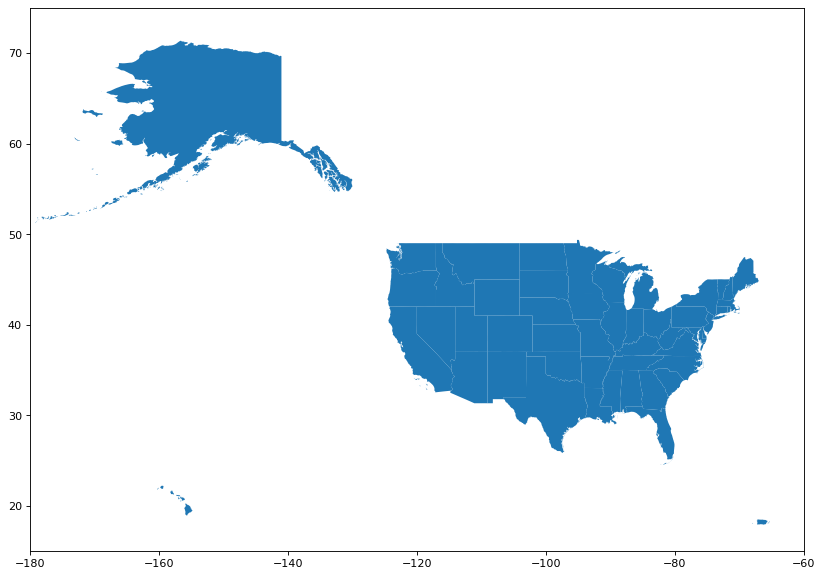

In [11]:
fig, ax = plt.subplots(figsize=(16, 9),dpi=80)
ax = US_gpd.plot(ax=ax)

plt.xlim([-180, -60])
plt.ylim([15, 75])
plt.show()

### Tighten up the view

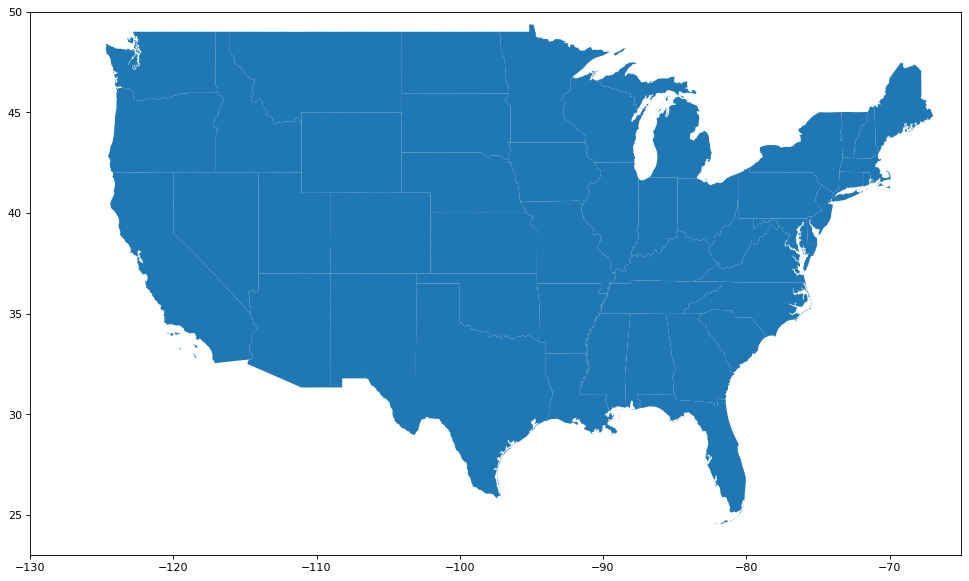

In [12]:
fig, ax = plt.subplots(figsize=(16, 9),dpi=80)
ax = US_gpd.plot(ax=ax)

plt.xlim([-130, -65])
plt.ylim([23, 50])
plt.show()

In [13]:
#us["area"] = us.area
#us.explore("area", legend=False)

### Add label & arrow for state name

Get coordinate for state name label

In [14]:
def get_Coords(df_Main):
    df_Main['coords'] = df_Main['geometry'].apply(lambda x: x.representative_point().coords[:])
    df_Main['coords'] = [coords[0] for coords in df_Main['coords']]
    return df_Main

US_gpd = get_Coords(US_gpd)

Manual improvement of some state name overlap problems

In [15]:
# list of overlap states
overlap_state = ['Vermont','New Hampshire','Massachusetts','Rhode Island','Connecticut','New Jersey','Delaware','Maryland','West Virginia','District of Columbia','Alabama']

old_position = {'Vermont':[-72.7721723206516, 43.871287499999994],\
                'New Hampshire':[-71.55153363075382, 44.001686],\
                'Massachusetts':[-72.0906137083712, 42.148081000000005],\
                'Rhode Island':[-71.59827076340775, 41.662519],\
                'Connecticut':[-72.66284659760579, 41.5034435],\
                'New Jersey':[-74.37884099984127, 40.1403525],\
                'Delaware':[-75.5789503410023, 39.149795499999996],\
                'Maryland':[-76.75274030690827, 38.817387],\
                'West Virginia':[-80.29656250731031, 38.918831499999996],\
                'District of Columbia':[-76.98977922083728, 38.8960115],\
                'Alabama':[-86.73307855039542, 32.613208]
               }

new_position = {'Vermont':[-72.7721723206516, 46.871287499999994],\
                'New Hampshire':[-62.55153363075382, 44.001686],\
                'Massachusetts':[-62.590613708371194, 42.648081000000005],\
                'Rhode Island':[-63.098270763407754, 41.162519],\
                'Connecticut':[-64.16284659760579, 40.103443500000004],\
                'New Jersey':[-63.98977922083728, 38.8960115],\
                'Delaware':[-66.12884099984127, 37.6903525],\
                'Maryland':[-67.3289503410023, 36.4997955],\
                'West Virginia':[-79.79656250731031, 44.068831499999995],\
                'District of Columbia':[-68.75274030690827, 35.317387],\
                'Alabama':[-86.73307855039542, 26.613208]
               }

arrow_position = {'Vermont':[-72.7721723206516, 46.871287499999994],\
                'New Hampshire':[-66.15153363075382, 44.401686],\
                'Massachusetts':[-65.880613708371194, 42.898081000000005],\
                'Rhode Island':[-65.998270763407754, 41.562519],\
                'Connecticut':[-66.96284659760579, 40.403443500000004],\
                'New Jersey':[-66.70977922083728, 39.2060115],\
                'Delaware':[-68.12884099984127, 38.0203525],\
                'Maryland':[-69.3289503410023, 36.9597955],\
                'West Virginia':[-79.79656250731031, 44.068831499999995],\
                'District of Columbia':[-69.75274030690827, 35.917387],\
                'Alabama':[-86.73307855039542, 27.013208]
               }

In [16]:
# Check old position by overlap state list
for s in overlap_state:
    print(US_gpd.at[s,'coords'])
    
# Change and seek for new location
#s = overlap_state[10]
#y = US_gpd.loc[s]['coords']
#x -= 0.25
#y += 0.15
#US_gpd.at[s,'coords'] = (x,y)
#US_gpd.at[s,'coords']

(-72.7721723206516, 43.871287499999994)
(-71.55153363075382, 44.001686)
(-72.0906137083712, 42.148081000000005)
(-71.59827076340775, 41.662519)
(-72.66284659760579, 41.5034435)
(-74.37884099984127, 40.1403525)
(-75.5789503410023, 39.149795499999996)
(-76.75274030690827, 38.817387)
(-80.29656250731031, 38.918831499999996)
(-76.98977922083728, 38.8960115)
(-86.73307855039542, 32.613208)


In [17]:
# Change location by position dict
df_new_pos = pd.DataFrame.from_dict(new_position,orient='index')
df_old_pos = pd.DataFrame.from_dict(old_position,orient='index')
df_arrow_pos = pd.DataFrame.from_dict(arrow_position,orient='index')

# Construct tuple for coords with x and y axis position
df_new_pos['coords']=df_new_pos[[0,1]].apply(tuple,axis=1)
df_old_pos['old_coords']=df_old_pos[[0,1]].apply(tuple,axis=1)
df_arrow_pos['arrow_coords']=df_arrow_pos[[0,1]].apply(tuple,axis=1)

# Drop the useless columns
df_new_pos = df_new_pos.drop(columns=[0,1])
df_old_pos = df_old_pos.drop(columns=[0,1])
df_arrow_pos = df_arrow_pos.drop(columns=[0,1])

# Update the original table
US_gpd.update(df_new_pos)

# Merge new & old position in one df
df_overlap_pos = pd.concat([df_new_pos['coords'].rename('new'), \
                            df_old_pos['old_coords'].rename('old'),\
                            df_arrow_pos['arrow_coords'].rename('arrow')],\
                           axis = 1)

In [18]:
print(df_overlap_pos.shape)
df_overlap_pos.head()

(11, 3)


,new,old,arrow
Vermont,"(-72.7721723206516, 46.871287499999994)","(-72.7721723206516, 43.871287499999994)","(-72.7721723206516, 46.871287499999994)"
New Hampshire,"(-62.55153363075382, 44.001686)","(-71.55153363075382, 44.001686)","(-66.15153363075382, 44.401686)"
Massachusetts,"(-62.590613708371194, 42.648081000000005)","(-72.0906137083712, 42.148081000000005)","(-65.8806137083712, 42.898081000000005)"
Rhode Island,"(-63.098270763407754, 41.162519)","(-71.59827076340775, 41.662519)","(-65.99827076340776, 41.562519)"
Connecticut,"(-64.16284659760579, 40.103443500000004)","(-72.66284659760579, 41.5034435)","(-66.96284659760579, 40.4034435)"


# Visualising NEV sales
Add the ev sales data into the map dataframe as follows:

In [19]:
US_Sales = pd.concat([df_EV, US_gpd], axis = 1)
US_Sales['State'] = US_Sales.index
US_Sales['Avg'] = US_Sales[['2016','2017','2018','2019']].mean(axis=1)
US_Sales.head()

,2016,2017,2018,2019,geometry,coords,State,Avg
Alabama,0.000067,0.000077,0.000174,0.000201,"MULTIPOLYGON (((-88.12466 30.28364, -88.08681 ...","(-86.73307855039542, 26.613208)",Alabama,0.000130
Alaska,0.000126,0.000115,0.000210,0.000195,"MULTIPOLYGON (((-166.10574 53.98861, -166.0752...","(-152.91343141521298, 62.878043500000004)",Alaska,0.000161
Arizona,0.000333,0.000433,0.001017,0.001074,"POLYGON ((-112.53859 37.00067, -112.53454 37.0...","(-111.66851071789918, 34.1684675)",Arizona,0.000714
Arkansas,0.000046,0.000063,0.000145,0.000179,"POLYGON ((-94.04296 33.01922, -94.04304 33.079...","(-92.49853688179809, 34.7509515)",Arkansas,0.000108
California,0.001883,0.002406,0.003881,0.003667,"MULTIPOLYGON (((-122.42144 37.86997, -122.4213...","(-119.9915015382688, 37.27239)",California,0.002959


Try converting the merged dataframe into a geodataframe

In [20]:
US_Sales = GeoDataFrame(US_Sales)

devide data into main & outside

In [21]:
df_Alaska = US_Sales[US_Sales.index == 'Alaska']
df_Hawaii = US_Sales[US_Sales.index == 'Hawaii']
df_Main = US_Sales.drop(index=('Alaska'))
df_Main = df_Main.drop(index=('Hawaii'))
len(US_Sales),len(df_Main)

(52, 50)

Re-draw the graph to use the sales data as the basis for each county's colour through setup the colour map.

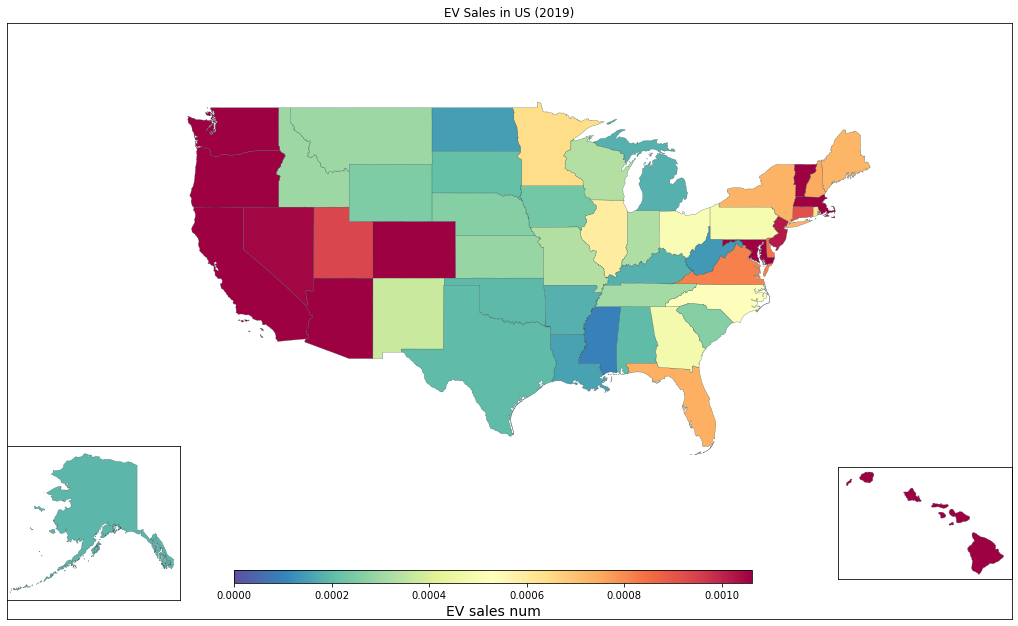

In [22]:
fig = plt.figure(figsize=[18,18])
ax = fig.add_subplot(111)

# Since California has the highest number and is 9.7 times than others, 
# we used the average of the top 5 to adjust our color range.
max_sale = US_Sales['2019'].head(5).mean()

# Setup the colour map and normalise it.
norm = matplotlib.colors.Normalize(vmin=0, vmax=max_sale)
cmap = matplotlib.cm.get_cmap('Spectral_r')

# Draw US main map
df_Main.plot(column='2019', cmap=cmap, norm=norm, ax=ax, lw=.25, edgecolor='darkslategrey')

# Tighten up the view
plt.xlim([-140, -55])
plt.ylim([13, 55])

# Remove unnecessary tick marks.
def remove_tick_mark(ax):
    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
remove_tick_mark(ax)

# Set title label.
ax.set_title('EV Sales in US (2019)')

# Add the colour bar and label it.
cax = fig.add_axes([.3, .30, .4, .01])
cb = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', orientation='horizontal')
cb.set_label('EV sales num', fontsize=14)


# Draw Alaska Map
ax = fig.add_subplot(5,5,16)
df_Alaska.plot(column='2019', cmap=cmap, norm=norm, ax=ax, lw=.25, edgecolor='darkslategrey')
# Tighten up the view
plt.xlim([-180, -128])
# Remove unnecessary tick marks.
remove_tick_mark(ax)

# Draw Hawaii Map
ax = fig.add_subplot(5,5,20)
df_Hawaii.plot(column='2019', cmap=cmap, norm=norm, ax=ax, lw=.25, edgecolor='darkslategrey')
# Remove unnecessary tick marks.
remove_tick_mark(ax)

### Draw map with state name

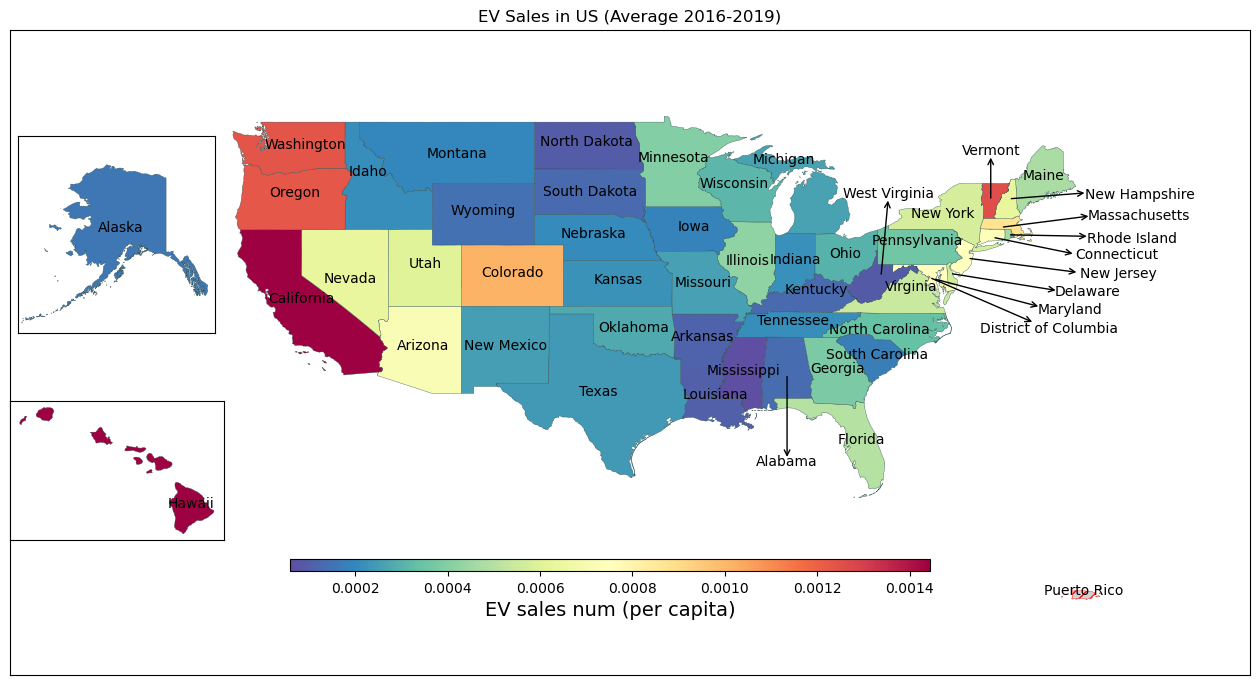

In [23]:
def draw_US_map_with_label(max_,min_,df_Main,df_Alaska,df_Hawaii,title,bar_title,c_ax):
    fig = plt.figure(figsize=[16,12],dpi=100)
    ax = fig.add_subplot(111)
    
    # Setup the colour map and normalise it.
    norm = matplotlib.colors.Normalize(vmin=min_, vmax=max_)
    cmap = matplotlib.cm.get_cmap('Spectral_r')

    # Draw US main map
    df_Main.plot(column='Avg', cmap=cmap, norm=norm, ax=ax, lw=.25, edgecolor='darkslategrey',\
                 missing_kwds={"color": "lightgrey","edgecolor": "red","hatch": "///","label": "Missing values"})

    # Draw state names
    for idx, row in df_Main.iterrows():
       plt.annotate(text=row['State'], xy=row['coords'], horizontalalignment='center', color='black')
    # Draw arrow for overlapped name
    for idx, row in df_overlap_pos.iterrows():
        ax.annotate("", xy=row['arrow'], xytext=row['old'],arrowprops=dict(arrowstyle="->"))
    
    # Tighten up the view
    plt.xlim([-140, -55])
    plt.ylim([13, 55])

    # Remove unnecessary tick marks.
    remove_tick_mark(ax)

    # Set title label.
    ax.set_title(title)

    # Add the colour bar and label it.
    cax = fig.add_axes(c_ax)
    cb = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', orientation='horizontal')
    cb.set_label(bar_title, fontsize=14)

    # Draw Alaska Map
    ax = fig.add_subplot(4,5,6)
    df_Alaska.plot(column='Avg', cmap=cmap, norm=norm, ax=ax, lw=.25, edgecolor='darkslategrey',\
                   missing_kwds={"color": "lightgrey","edgecolor": "red",\
                                 "hatch": "///","label": "Missing values"}\
                  )
    # Tighten up the view
    plt.xlim([-180, -128])
    plt.ylim([50,75])
    # Show Alaska name
    plt.annotate(text='Alaska', xy=df_Alaska['coords']['Alaska'], horizontalalignment='center', color='black')
    # Remove unnecessary tick marks.
    remove_tick_mark(ax)
    
    # Draw Hawaii Map
    ax = fig.add_subplot(4,5,11)
    df_Hawaii.plot(column='Avg', cmap=cmap, norm=norm, ax=ax, lw=.25, edgecolor='darkslategrey',\
                   missing_kwds={"color": "lightgrey","edgecolor": "red",\
                                 "hatch": "///","label": "Missing values"}\
                  )
    # Show Hawaii name
    plt.annotate(text='Hawaii', xy=df_Hawaii['coords']['Hawaii'], horizontalalignment='center', color='black');
    # Remove unnecessary tick marks.
    remove_tick_mark(ax)
    
    return fig
# Since California has the highest number and is 9.7 times than others, 
# we used the average of the top 15 to adjust our color range.
US_Sales.sort_values(by=['Avg'],ascending=False, inplace=True)
max_sale = US_Sales['Avg'].head(7).mean()
min_sale = US_Sales['Avg'].min()
title = 'EV Sales in US (Average 2016-2019)'
bar_title = 'EV sales num (per capita)'
# Set colour bar position.
c_ax = [.3, .32, .4, .01]
fig = draw_US_map_with_label(max_sale,min_sale,df_Main,df_Alaska,df_Hawaii,title,bar_title,c_ax)

# Save as png image
fig.savefig('./US_Maps/EV_Sales_in_US.png', format='png')

## Show Climate Map

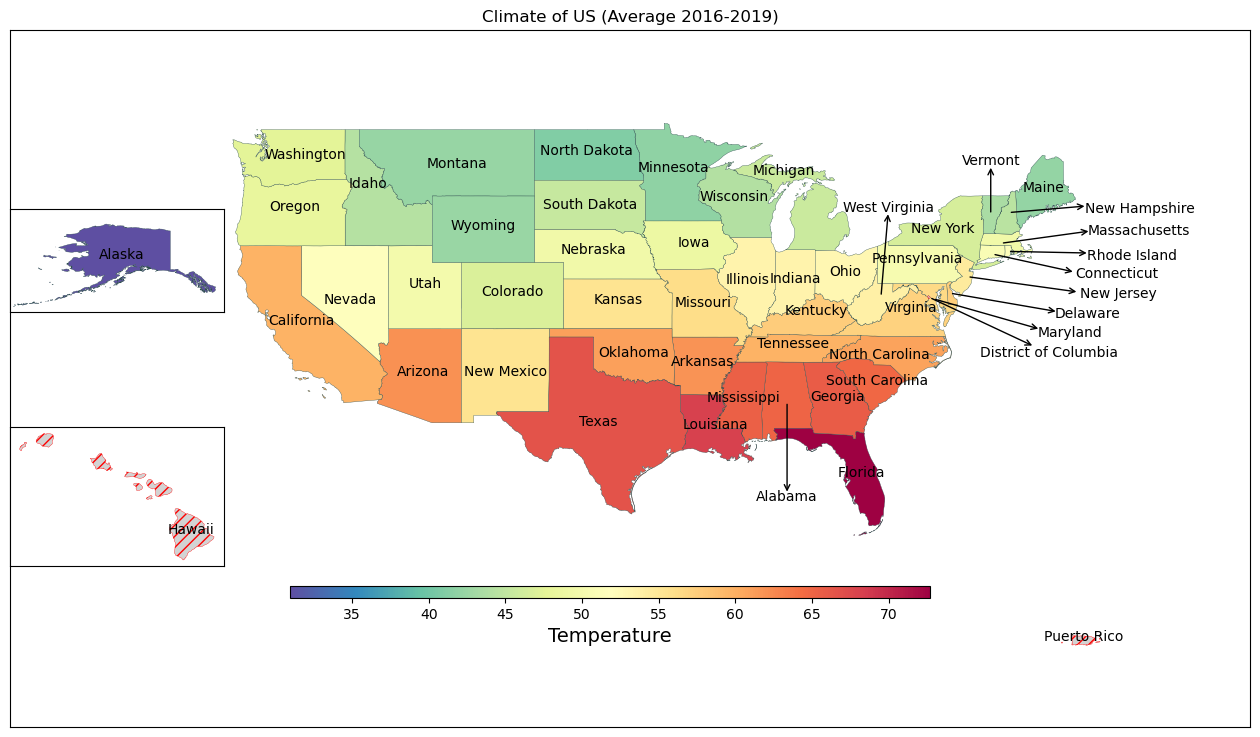

In [24]:
US_Climate = pd.concat([df_Climate[['2016','2017','2018','2019']].mean(axis=1).rename('Avg'), US_gpd], axis = 1)
US_Climate['State'] = US_Climate.index

US_Climate = GeoDataFrame(US_Climate)

df_Alaska_c = US_Climate[US_Climate.index == 'Alaska']
df_Hawaii_c = US_Climate[US_Climate.index == 'Hawaii']
df_Main_c = US_Climate.drop(index=('Alaska'))
df_Main_c = df_Main_c.drop(index=('Hawaii'))

# Setting for adjust color range
max_temp = US_Climate['Avg'].max()
min_temp = US_Climate['Avg'].min()
title = 'Climate of US (Average 2016-2019)'
bar_title = 'Temperature'
# Set colour bar position.
c_ax = [.3, .32, .4, .01]
fig = draw_US_map_with_label(max_temp,min_temp,df_Main_c,df_Alaska_c,df_Hawaii_c,title,bar_title,c_ax)

# Save as png image
fig.savefig('./US_Maps/Climate_in_US.png', format='png')

## Show Income Map

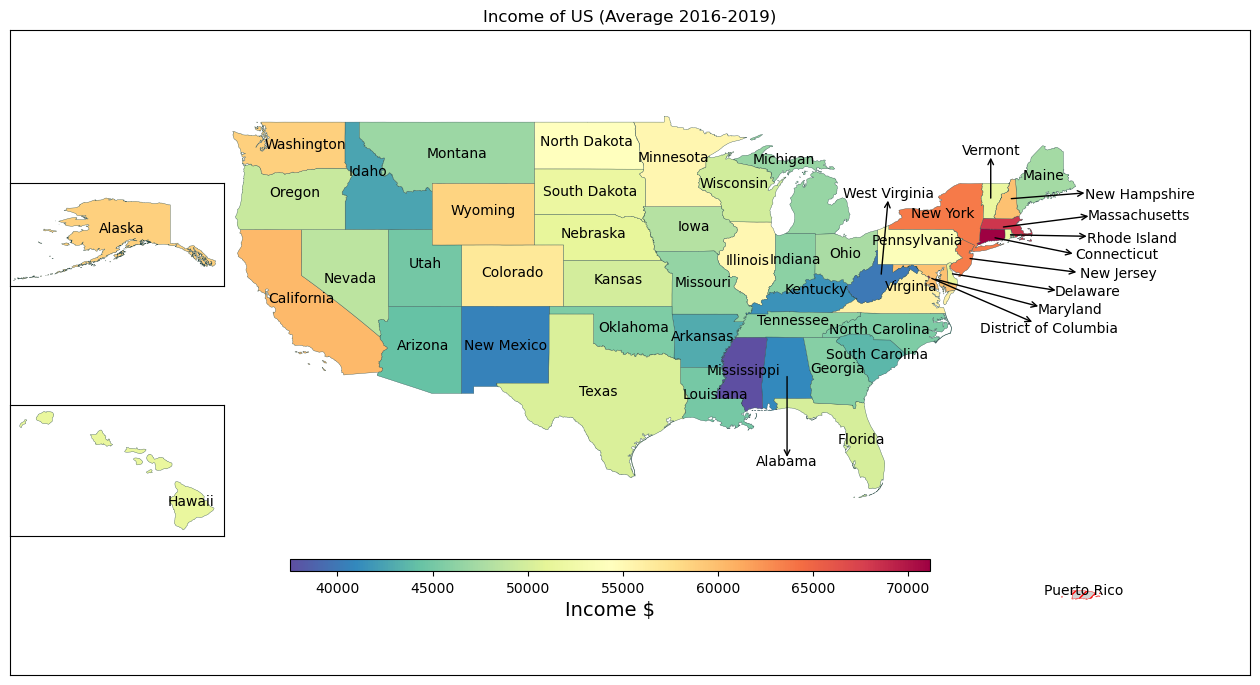

In [25]:
US_Income = pd.concat([df_Income[['2016','2017','2018','2019']].mean(axis=1).round(2).rename('Avg'), US_gpd], axis = 1)
US_Income['State'] = US_Income.index

US_Income = GeoDataFrame(US_Income)

df_Alaska_i = US_Income[US_Income.index == 'Alaska']
df_Hawaii_i = US_Income[US_Income.index == 'Hawaii']
df_Main_i = US_Income.drop(index=('Alaska'))
df_Main_i = df_Main_i.drop(index=('Hawaii'))

# Setting for adjust color range
US_Income = US_Income.sort_values(by=['Avg'],ascending=False)
max_income = US_Income['Avg'].head(4).mean()
min_income = US_Income['Avg'].min()
title = 'Income of US (Average 2016-2019)'
bar_title = 'Income $'
# Set colour bar position.
c_ax = [.3, .32, .4, .01]
fig = draw_US_map_with_label(max_income,min_income,df_Main_i,df_Alaska_i,df_Hawaii_i,title,bar_title,c_ax)

# Save as png image
fig.savefig('./US_Maps/Income_in_US.png', format='png')

## Show Tax Map

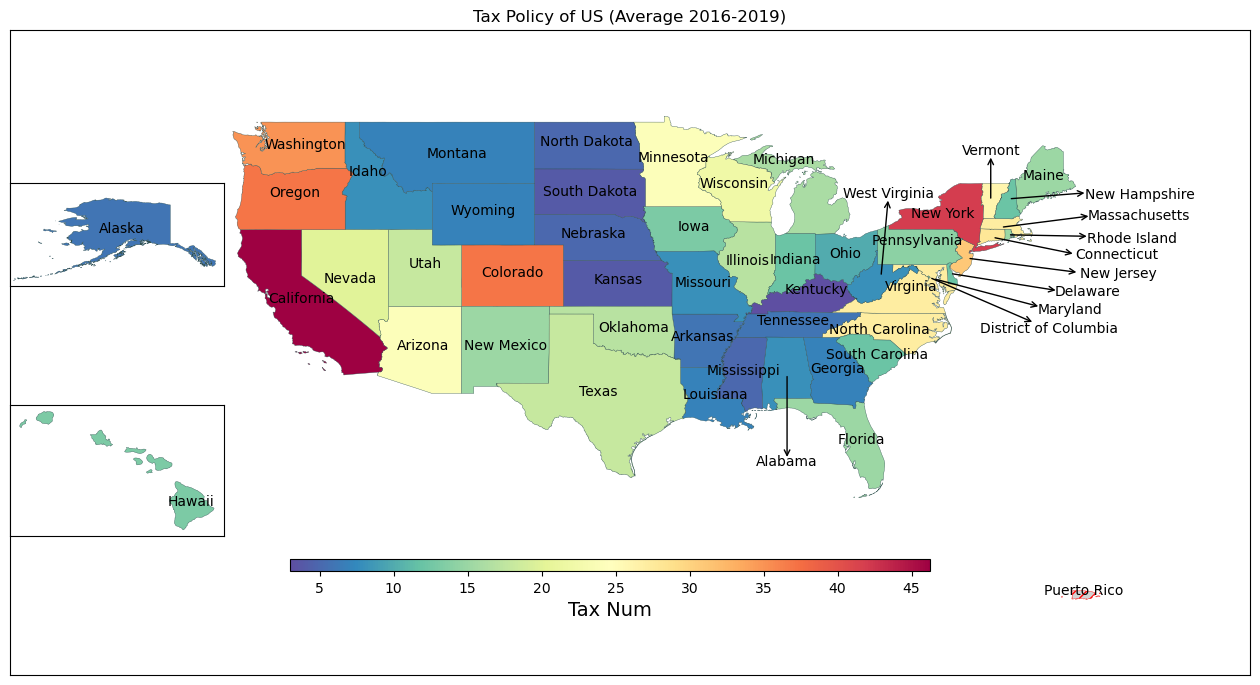

In [26]:
US_Tax = pd.concat([df_Tax['Total'].rename('Avg'), US_gpd], axis = 1)
US_Tax['State'] = US_Tax.index

US_Tax = GeoDataFrame(US_Tax)

df_Alaska_t = US_Tax[US_Tax.index == 'Alaska']
df_Hawaii_t = US_Tax[US_Tax.index == 'Hawaii']
df_Main_t = US_Tax.drop(index=('Alaska'))
df_Main_t = df_Main_t.drop(index=('Hawaii'))

# Setting for adjust color range
US_Tax = US_Tax.sort_values(by=['Avg'],ascending=False)
max_tax = US_Tax['Avg'].head(8).mean()
min_tax = US_Tax['Avg'].min()
title = 'Tax Policy of US (Average 2016-2019)'
bar_title = 'Tax Num'
# Set colour bar position.
c_ax = [.3, .32, .4, .01]
fig = draw_US_map_with_label(max_tax,min_tax,df_Main_t,df_Alaska_t,df_Hawaii_t,title,bar_title,c_ax)

# Save as png image
fig.savefig('./US_Maps/Tax_in_US.png', format='png')

## Show GDP Map

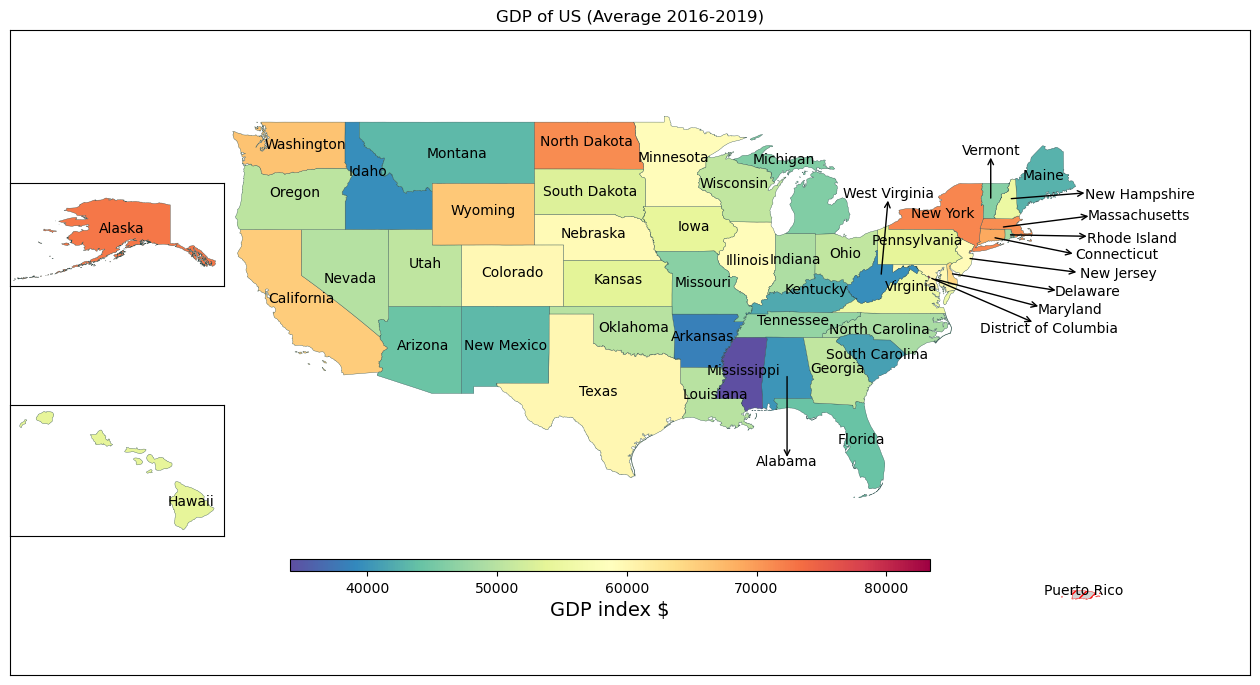

In [27]:
US_GDP = pd.concat([df_GDP[['2016','2017','2018','2019']].mean(axis=1).round(2).rename('Avg'), US_gpd], axis = 1)
US_GDP['State'] = US_GDP.index

US_GDP = GeoDataFrame(US_GDP)

df_Alaska_g = US_GDP[US_GDP.index == 'Alaska']
df_Hawaii_g = US_GDP[US_GDP.index == 'Hawaii']
df_Main_g = US_GDP.drop(index=('Alaska'))
df_Main_g = df_Main_g.drop(index=('Hawaii'))

# Setting for adjust color range
US_GDP = US_GDP.sort_values(by=['Avg'],ascending=False)
max_gdp = US_GDP['Avg'].head(8).mean()
min_gdp = US_GDP['Avg'].min()
title = 'GDP of US (Average 2016-2019)'
bar_title = 'GDP index $'
# Set colour bar position.
c_ax = [.3, .32, .4, .01]
fig = draw_US_map_with_label(max_gdp,min_gdp,df_Main_g,df_Alaska_g,df_Hawaii_g,title,bar_title,c_ax)

# Save as png image
fig.savefig('./US_Maps/GDP_in_US.png', format='png')